# Mapping the Latent Space of CXR Patient Geometry
## Zebrastack V0 VAE trained on the CovidNet chest radiograph dataset
The zebrastack is a variational auto-encoder that is _very_ roughly aligned with the distributed hierarchical architecture + shifter circuit.  Here it is applied to recognition of the CovidNet chest radiograph dataset.

First, declare some helper pyplot functions to show us thumbnails.

In [1]:
# %load show_original_decoded.py
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz, n=10):
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

Now load the center-surround processed images

In [15]:
# now reload
from pathlib import Path
import os
import time

start_time = time.time()

clahe_temp_path = Path(os.environ['DATA_TEMP']) / 'anat0mixer_temp' / 'clahe_processed'
processed_imgs = {}
for npy_filepath in clahe_temp_path.glob('*.npy'):
    import numpy as np
    processed_imgs[npy_filepath.stem] = np.load(npy_filepath)
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

Loaded 60361 npy in 127.22431182861328 seconds


Determine shape of processed images

In [17]:
one_img = list(processed_imgs.values())[0]
sz = one_img.shape[0]
processed_imgs = {tpl[0]:np.reshape(tpl[1], (sz,sz,1)) for tpl in processed_imgs.items()}
print(f"Processed images are {sz}x{sz}x1")

Processed images are 128x128x1


Partition the data in to train and test: 90% train and 10% test.  We are assuming all images are from distinct patients, so there is no need to partition by subject.

In [18]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

Training data has shape (54325, 128, 128, 1)
Testing data has shape (6036, 128, 128, 1)


## Defining the Variational Autoencoder
To defined the variational autoencoder, we need to helper functions:
* A function for reparameterized sampling
* A function for KLDiv loss

In [2]:
# %load zebrastack_v0_model.py
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K

sz = 128
latent_dim = 12
locally_connected_channels = 2
do_plot_model = False
cit_decimate = False
act_func = 'softplus' # or 'relu'
use_mse = True # False

def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

def create_encoder():
    """
    """
    # create encoder side
    retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

    v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation=act_func, padding='same')(retina)
    v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
    v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

    v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation=act_func, padding='same')(v1_dropout)
    v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

    v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation=act_func, padding='same')(v2_maxpool)
    v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

    pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation=act_func, padding='same')(v4_maxpool)
    pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

    cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation=act_func, padding='same')(pit_maxpool)
    if cit_decimate:
        cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)
        cit_out = cit_maxpool
    else:
        cit_out = cit_conv2d

    ait_local = LocallyConnected2D(locally_connected_channels, (3,3), 
                                   name='ait_local', activation=act_func)(cit_out)
    # ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
    # x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

    ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_local)

    # shape info needed to build decoder model
    shape = K.int_shape(ait_regular)
    # print(shape)

    # generate latent vector Q(z|X)
    pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
    pulvinar_dense = Dense(latent_dim, activation=act_func, name='pulvinar_dense')(pulvinar_flatten)
    z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
    z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
    encoder.summary()
    
    if do_plot_model: 
        plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

    return retina, encoder, shape, [z_mean, z_log_var, z]

def create_decoder(shape):
    """
    """
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    pulvinar_dense_back = Dense(shape[1] * shape[2] * shape[3], name='pulvinar_dense_back', 
                                activation=act_func)(latent_inputs)
    pulvinar_antiflatten = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(pulvinar_dense_back)

    ait_padding_back = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(pulvinar_antiflatten)
    ait_local_back = LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local_back', 
                                        activation=act_func)(ait_padding_back)

    cit_padding_back = ZeroPadding2D(padding=(1,1), name='cit_padding_back')(ait_local_back)
    if cit_decimate:
        ait_upsample_back = UpSampling2D((2,2), name='ait_upsample_back')(cit_padding_back)
        ait_out_back = ait_upsample_back
    else:
        ait_out_back = cit_padding_back

    cit_conv2d_trans = Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', 
                                       activation=act_func, padding='same')(ait_out_back)
    cit_upsample_back = UpSampling2D((2,2), name='cit_upsample_back')(cit_conv2d_trans)

    pit_conv2d_trans = Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', 
                                       activation=act_func, padding='same')(cit_upsample_back)
    pit_upsample_back = UpSampling2D((2,2), name='pit_upsample_back')(pit_conv2d_trans)

    v4_conv2d_trans = Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', 
                                      activation=act_func, padding='same')(pit_upsample_back)
    v4_upsample_back = UpSampling2D((2,2), name='v4_upsample_back')(v4_conv2d_trans)

    v2_conv2d_trans = Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', 
                                      activation=act_func, padding='same')(v4_upsample_back)
    v2_upsample_back = UpSampling2D((2,2), name='v2_upsample_back')(v2_conv2d_trans)

    v1_conv2d_5x5_back = Conv2D(1, (5,5), name='v1_conv2d_5x5_back', 
                                activation='sigmoid', padding='same')(v2_upsample_back)
    decoder = Model(latent_inputs, v1_conv2d_5x5_back, name='pulvinar_to_v1_decoder')
    decoder.summary()
    if do_plot_model: 
        plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)
        
    return decoder

def create_autoencoder(retina, encoder, prob_model, decoder):
    """
    """
    autoencoder_output = decoder(encoder(retina)[2])
    autoencoder = Model(retina, autoencoder_output, name='v1_to_pulvinar_vae')

    # now compile with the optimizer VAE loss function
    optimizer = 'adadelta'
    [z_mean, z_log_var, z] = prob_model
    autoencoder.compile(optimizer=optimizer, 
                        loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
    autoencoder.summary()
    if do_plot_model: 
        plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)
        
    return autoencoder

Using TensorFlow backend.


In [3]:
retina, encoder, latent_shape, [z_mean, z_log_var, z] = create_encoder()
decoder = create_decoder(latent_shape)
autoencoder = create_autoencoder(retina, encoder, [z_mean, z_log_var, z], decoder)

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [ ]:
def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
use_mse = True # False
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

We create the Keras model in three parts: 
* encode_only: the recognition subsystem(encoder)
* decode_only: decoder
* autoencoder: the full system

Parameters that control the model are:
* sz: size x size of inputs
* latent_dim: latent dimension at the pulvinar

The layers are named to suggest correspondence between each layer and an area in the distributed hierarchy model / shifter circuit.

In [ ]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras import backend as K

sz = 128
latent_dim = 12
do_plot_model = False
cit_decimate = False
act_func = 'softplus' # or 'relu'

# create encoder side
retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation=act_func, padding='same')(retina)
v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation=act_func, padding='same')(v1_dropout)
v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation=act_func, padding='same')(v2_maxpool)
v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation=act_func, padding='same')(v4_maxpool)
pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation=act_func, padding='same')(pit_maxpool)
if cit_decimate:
    cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)
    cit_out = cit_maxpool
else:
    cit_out = cit_conv2d
    
locally_connected_channels = 2    
ait_local = LocallyConnected2D(locally_connected_channels, (3,3), 
                               name='ait_local', activation=act_func)(cit_out)
# ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
# x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_local)

# shape info needed to build decoder model
shape = K.int_shape(ait_regular)
# print(shape)

# generate latent vector Q(z|X)
pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
pulvinar_dense = Dense(latent_dim, activation=act_func, name='pulvinar_dense')(pulvinar_flatten)
z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

from keras.models import Model
encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
encoder.summary()
    
from keras.utils import plot_model
if do_plot_model: 
    plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

The decoder is defined as the reverse layers of the encoder.

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
pulvinar_dense_back = Dense(shape[1] * shape[2] * shape[3], name='pulvinar_dense_back', 
                            activation=act_func)(latent_inputs)
pulvinar_antiflatten = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(pulvinar_dense_back)

ait_padding_back = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(pulvinar_antiflatten)
ait_local_back = LocallyConnected2D(locally_connected_channels, (3,3), name='ait_local_back', 
                                    activation=act_func)(ait_padding_back)

cit_padding_back = ZeroPadding2D(padding=(1,1), name='cit_padding_back')(ait_local_back)
if cit_decimate:
    ait_upsample_back = UpSampling2D((2,2), name='ait_upsample_back')(cit_padding_back)
    ait_out_back = ait_upsample_back
else:
    ait_out_back = cit_padding_back
    
cit_conv2d_trans = Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', 
                                   activation=act_func, padding='same')(ait_out_back)
cit_upsample_back = UpSampling2D((2,2), name='cit_upsample_back')(cit_conv2d_trans)

pit_conv2d_trans = Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', 
                                   activation=act_func, padding='same')(cit_upsample_back)
pit_upsample_back = UpSampling2D((2,2), name='pit_upsample_back')(pit_conv2d_trans)

v4_conv2d_trans = Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', 
                                  activation=act_func, padding='same')(pit_upsample_back)
v4_upsample_back = UpSampling2D((2,2), name='v4_upsample_back')(v4_conv2d_trans)

v2_conv2d_trans = Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', 
                                  activation=act_func, padding='same')(v4_upsample_back)
v2_upsample_back = UpSampling2D((2,2), name='v2_upsample_back')(v2_conv2d_trans)

v1_conv2d_5x5_back = Conv2D(1, (5,5), name='v1_conv2d_5x5_back', 
                            activation='sigmoid', padding='same')(v2_upsample_back)
decoder = Model(latent_inputs, v1_conv2d_5x5_back, name='pulvinar_to_v1_decoder')
decoder.summary()
if do_plot_model: 
    plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)

Finally put it together to the full model, and compile with the desired optimizer

In [ ]:
autoencoder_output = decoder(encoder(retina)[2])
autoencoder = Model(retina, autoencoder_output, name='v1_to_pulvinar_vae')

# now compile with the optimizer VAE loss function
optimizer = 'adadelta'
autoencoder.compile(optimizer=optimizer, 
                    loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
autoencoder.summary()
if do_plot_model: 
    plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)

## Pre-Training the model
Train by calling .fit with the training data.  
* Batch size of 512 helps convergence, but causes resource exhaustion > 128x128.
* Epochs > 1024 take a while, but tend to lead to better results

In [ ]:
autoencoder.fit(x_train[:5000], x_train[:5000], 
                epochs=128, batch_size=128, 
                shuffle=True, validation_data=(x_test[:500], x_test[:500]))

## Inspecting Reconstructing Images
To qualitatively assess the model, look at a few images and their reconstructions from latent vectors

In [19]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

In [ ]:
from tensorflow import keras
reload_models = False
if reload_models:
    encoder = keras.models.load_model('data\zebrastack_v0_covidnet_encoder_model')
    decoder = keras.models.load_model('data\zebrastack_v0_covidnet_decoder_model')

<IPython.core.display.Javascript object>


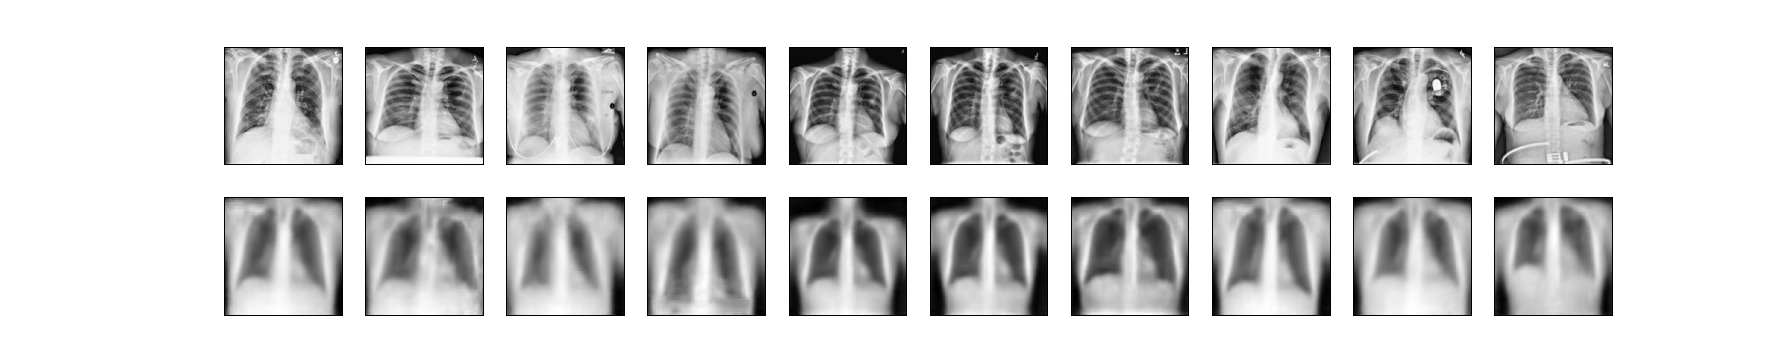

In [20]:
encode_only_imgs = encoder.predict(x_test[:10])
show_histo = False
if show_histo:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [ ]:
import tensorflow as tf
autoencoder.save_weights('E:\\Data\\anat0mixer_temp\\autoencoder_v0')
encoder.save_weights('E:\\Data\\anat0mixer_temp\\encoder_v0')
decoder.save_weights('E:\\Data\\anat0mixer_temp\\decoder_v0')

In [9]:
import tensorflow as tf
from pathlib import Path
from os import environ
fully_trained = Path(environ['DATA_TEMP']) / 'anat0mixer_temp' / 'shifter_processed' / 'weights'
autoencoder.load_weights(fully_trained / '202008201514_autoencoder.h5')
encoder.load_weights(fully_trained / '202008201514_encoder.h5')
decoder.load_weights(fully_trained / '202008201514_decoder.h5')

## Apply Shifter to Dataset

In [ ]:
use_rotation, use_shear = False, False
dump = False
weight_prior = 1.0/1000.0
count_imgs = 0

def xform_params(x):
    import math
    params = {'tx':x[0], 'ty':x[1], 'zx':math.exp(x[2]/30), 'zy':math.exp(x[3]/30)}
    if use_rotation:
        params['theta'] = x[4]
    if use_shear:
        params['shear'] = x[5]
    return params

def xform_image(params, img):
    from tensorflow.keras.preprocessing.image import apply_affine_transform as transform
    return transform(img, **params, fill_mode='nearest')

def xform_prior_logsq(x):
    theta_prior = x[0] * x[0]
    shear_prior = x[5] * x[5]
    scale_prior = x[3] * x[3] + x[4] * x[4]
    return theta_prior + shear_prior + scale_prior

def xformed_latent(x, img):
    params = xform_params(x)
    xformed = xform_image(params, img)
    latent_vector = encoder.predict([[xformed]])[2]
    # prior = xform_prior_logsq(x)
    return np.linalg.norm(latent_vector) # + weight_prior * prior
    
def shift(img):
    from scipy.optimize import minimize
    import pprint
    global count_imgs
    res = minimize(xformed_latent, np.zeros((4,)),
                   method='powell', 
                   # method='nelder-mead', 
                   args=img,
                   options={'xtol': 1e-6, 
                            'ftol': 1e-6,
                            # 'maxiter': 10000,
                            'disp': dump})
    params = xform_params(res.x)
    if dump:
        print(res)
        pprint.pprint(params)
    count_imgs = 1 + count_imgs
    print('{0}: {1},{2}'.format(count_imgs, res.x[0], res.x[1]), end = '\r')
    return xform_image(params, img)

x_train_shifted = []
for img in x_train:
    x_train_shifted.append(shift(img))
x_test_shifted = []
for img in x_test:
    x_test_shifted.append(shift(img))
show_original_decoded(x_test[:10], x_test_shifted[:10], sz)

In [ ]:
shift_processed_path = "E:\\Data\\anat0mixer_temp\\shifter_processed"
for n in range(len(x_train_shifted)):
    np.save(shift_processed_path+f"\\x_train_shifted_{n}", 
            x_train_shifted[n])

In [ ]:
for n in range(len(x_test_shifted)):    
    np.save(shift_processed_path+f"\\x_test_shifted_{n}", 
            x_test_shifted[n])

In [ ]:
from pathlib import Path
x_train_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_train_shifted_*.npy')
x_train_shifted = []
for fn in x_train_fns:
    x_train_shifted.append(np.load(fn))

x_test_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_test_shifted_*.npy')
x_test_shifted = []
for fn in x_test_fns:
    x_test_shifted.append(np.load(fn))

In [ ]:
x_train_shifted = np.array(x_train_shifted)
x_test_shifted = np.array(x_test_shifted)
x_train_shifted.shape, x_test_shifted.shape

In [ ]:
autoencoder.fit(x_train_shifted, x_train_shifted, 
                epochs=256, batch_size=128, 
                shuffle=True, validation_data=(x_test_shifted, x_test_shifted))

In [ ]:
import tensorflow as tf
autoencoder.save_weights('E:\\Data\\anat0mixer_temp\\autoencoder_v1')
encoder.save_weights('E:\\Data\\anat0mixer_temp\\encoder_v1')
decoder.save_weights('E:\\Data\\anat0mixer_temp\\decoder_v1')

In [ ]:
encoded_shift = encoder.predict(x_test_shifted[80:90])
decoded_imgs_shift = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encoded_shift[2]]
show_original_decoded(x_test_shifted[80:90], decoded_imgs_shift, sz)

## Saving the Model
If the model output looks good, then save it for subsequent use

In [ ]:
encoder.save('data\zebrastack_v0_covidnet_encoder_model')
decoder.save('data\zebrastack_v0_covidnet_decoder_model')

## Anat0Mixer Interaction

In [10]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = decoded_pixel_array.reshape(sz,sz)
    # interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=0)
    # interp_array = interp_array.reshape(sz*4, sz*4)
    # ax.imshow(interp_array, cmap='gray')
    # a=im.get_array()    
    im.set_array(interp_array)
    fig.canvas.draw()
    return kwargs['1']

In [13]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}

for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

decoded_pixel_array = decode_latent(decoder, tuple([slider.value for slider in kwargs.values()]))
interp_array = decoded_pixel_array.reshape(sz,sz)


<IPython.core.display.Javascript object>


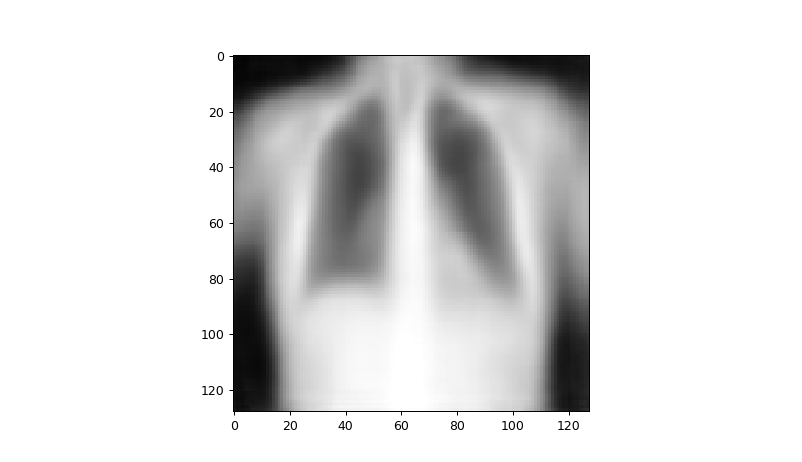

Output(layout=Layout(height='350px'))

In [14]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
im = ax.imshow(interp_array, cmap='gray')

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'

import gc
gc.disable()
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)

In [ ]:
gc.enable()